In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
andrewmvd_cyberbullying_classification_path = kagglehub.dataset_download('andrewmvd/cyberbullying-classification')

print('Data source import complete.')


Using Colab cache for faster access to the 'cyberbullying-classification' dataset.
Data source import complete.


In [2]:
print(andrewmvd_cyberbullying_classification_path)

/kaggle/input/cyberbullying-classification


# Detecting bullying Tweets with BERT Transformer Project

This project is about the analysis of tweets about cyberbullying, with the goal of performing a Sentiment Analysis using  BERT on PyTorch to predict if a tweet is about cyberbullying or not. <br>
In particular, bullying tweets are divided in 4 categories: religion, age, race and gender.<br>
The project is divided in the following sections:

- Data Import
- Text cleaning with custom defined functions
- Naive Bayes baseline model Classifier
- Data preparation for BERT: Tokenization
- PyTorch BERT Classifier
- Results summary


# Resumen de resultados principales:

![cyberbullying conf mat.png](attachment:6438c40d-3a97-4db7-a5ca-52e2e1332a08.png)

**Naive Bayes baseline classifier performed quite well on the dataset, with an overall accuracy of 85% among all the classes.<br>

**BERT performed the best, with an overall accuracy around 95% and F1 scores over 96%.**<br>
Overall, the algorithms could properly distinguish the different topics of the bullying tweets, and had little **more troubles** with the **less populated class "not cyberbullying" and the "gender" class (achieving lower precision and recall compared to other classes)**.<br>
For this reason, it could be a good idea to **collect more data of this classes** and aim to achieve higher accuracy and F1 score.

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv
/kaggle/input/cyberbullying-classification/.nfs0000000043f55b8c00000030


## Custom functions definition:

In [4]:
def conf_matrix(y, y_pred, title, labels):
    fig, ax =plt.subplots(figsize=(7.5,7.5))
    ax=sns.heatmap(confusion_matrix(y, y_pred), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
    plt.title(title, fontsize=25)
    ax.xaxis.set_ticklabels(labels, fontsize=16)
    ax.yaxis.set_ticklabels(labels, fontsize=14.5)
    ax.set_ylabel('Test', fontsize=25)
    ax.set_xlabel('Predicted', fontsize=25)
    plt.show()

In [5]:
pip install langdetect

In [6]:
pip install contractions

## Importar librarias

In [7]:
!pip install emoji
!pip install gensim
!pip install seaborn

In [8]:

# Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Text cleaning
import re
import string
import emoji
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

# Descargar si aún no lo hiciste
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')


# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from langdetect import detect, LangDetectException
import contractions
from nltk.tokenize import word_tokenize

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()

#plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


<Figure size 640x480 with 0 Axes>

## Data Import

In [9]:
df = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")

In [10]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47692 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_text          47692 non-null  object
 1   cyberbullying_type  47692 non-null  object
dtypes: object(2)
memory usage: 745.3+ KB


First we rename the columns using shorter words for easier reference.

In [12]:
df = df.rename(columns={'tweet_text': 'text', 'cyberbullying_type': 'sentiment'})

### Tweets duplicados?

In [13]:
df.duplicated().sum()

36

There are some duplicated tweets, we will remove them.

In [14]:
df = df[~df.duplicated()]

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47656 entries, 0 to 47691
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       47656 non-null  object
 1   sentiment  47656 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


### Classes desbalanceadas?

In [16]:
df.sentiment.value_counts()

,count
sentiment,
religion,7997
age,7992
ethnicity,7959
gender,7948
not_cyberbullying,7937
other_cyberbullying,7823


The classes look balanced.

# Limpieza de los Tweets

Next, we will define custom functions to clean the texts of the tweets.

In [17]:
# Clean emojis from text
def strip_emoji(text):
    return emoji.replace_emoji(text, replace="")

# Remove punctuations, stopwords, links, mentions and new line characters
def strip_all_entities(text):
    text = re.sub(r'\r|\n', ' ', text.lower())  # Replace newline and carriage return with space, and convert to lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)  # Remove links and mentions
    text = re.sub(r'[^\x00-\x7f]', '', text)  # Remove non-ASCII characters
    banned_list = string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

# Clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    # Remove hashtags at the end of the sentence
    new_tweet = re.sub(r'(\s+#[\w-]+)+\s*$', '', tweet).strip()

    # Remove the # symbol from hashtags in the middle of the sentence
    new_tweet = re.sub(r'#([\w-]+)', r'\1', new_tweet).strip()

    return new_tweet

# Filter special characters such as & and $ present in some words
def filter_chars(text):
    return ' '.join('' if ('$' in word) or ('&' in word) else word for word in text.split())

# Remove multiple spaces
def remove_mult_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Function to check if the text is in English, and return an empty string if it's not
def filter_non_english(text):
    try:
        lang = detect(text)
    except LangDetectException:
        lang = "unknown"
    return text if lang == "en" else ""

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Remove numbers
def remove_numbers(text):
    return re.sub(r'\d+', '', text)

# Lemmatize words
def lemmatize(text):
    words = word_tokenize(text)
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

# Remove short words
def remove_short_words(text, min_len=2):
    words = text.split()
    long_words = [word for word in words if len(word) >= min_len]
    return ' '.join(long_words)

# Replace elongated words with their base form
def replace_elongated_words(text):
    regex_pattern = r'\b(\w+)((\w)\3{2,})(\w*)\b'
    return re.sub(regex_pattern, r'\1\3\4', text)

# Remove repeated punctuation
def remove_repeated_punctuation(text):
    return re.sub(r'[\?\.\!]+(?=[\?\.\!])', '', text)

# Remove extra whitespace
def remove_extra_whitespace(text):
    return ' '.join(text.split())

def remove_url_shorteners(text):
    return re.sub(r'(?:http[s]?://)?(?:www\.)?(?:bit\.ly|goo\.gl|t\.co|tinyurl\.com|tr\.im|is\.gd|cli\.gs|u\.nu|url\.ie|tiny\.cc|alturl\.com|ow\.ly|bit\.do|adoro\.to)\S+', '', text)

# Remove spaces at the beginning and end of the tweet
def remove_spaces_tweets(tweet):
    return tweet.strip()

# Remove short tweets
def remove_short_tweets(tweet, min_words=3):
    words = tweet.split()
    return tweet if len(words) >= min_words else ""

# Function to call all the cleaning functions in the correct order
def clean_tweet(tweet):
    tweet = strip_emoji(tweet)
    tweet = expand_contractions(tweet)
    tweet = filter_non_english(tweet)
    tweet = strip_all_entities(tweet)
    tweet = clean_hashtags(tweet)
    tweet = filter_chars(tweet)
    tweet = remove_mult_spaces(tweet)
    tweet = remove_numbers(tweet)
    tweet = lemmatize(tweet)
    tweet = remove_short_words(tweet)
    tweet = replace_elongated_words(tweet)
    tweet = remove_repeated_punctuation(tweet)
    tweet = remove_extra_whitespace(tweet)
    tweet = remove_url_shorteners(tweet)
    tweet = remove_spaces_tweets(tweet)
    tweet = remove_short_tweets(tweet)
    tweet = ' '.join(tweet.split())  # Remove multiple spaces between words
    return tweet

In [18]:
df['text_clean'] = [clean_tweet(tweet) for tweet in df['text']]

In [19]:
df.head()

,text,sentiment,text_clean
0,"In other words #katandandre, your food was cra...",not_cyberbullying,word katandandre food crapilicious mkr
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying,aussietv white mkr theblock imacelebrityau tod...
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying,classy whore red velvet cupcake
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying,meh thanks head concerned another angry dude t...
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying,isi account pretending kurdish account like is...


### Are there duplicate tweets after the cleaning?

In [20]:
print(f'There are around {int(df["text_clean"].duplicated().sum())} duplicated tweets, we will remove them.')

There are around 6267 duplicated tweets, we will remove them.


In [21]:
df.drop_duplicates("text_clean", inplace=True)

We removed the duplicated cleaned tweets. How is the class balance after the cleaning?

In [22]:
df.sentiment.value_counts()

,count
sentiment,
religion,7917
age,7814
ethnicity,7416
gender,7277
not_cyberbullying,6060
other_cyberbullying,4905


**Se elimina la clase "other cyberbullying"**

We can see that lots of tweets of the class "other_cyberbullying" have been removed. Since the class is very unbalanced compared to the other classes and looks too "generic", we decide to remove the tweets labeled belonging to this class.<br>
EDIT: by performing some tests, the f1 score for predicting the "other_cyberbullying" resulted to be around 60%, a value far lower compared to the othter f1 scores (around 95% using LSTM model). This supports the decision of removing this generic class.

In [23]:
df = df[df["sentiment"]!="other_cyberbullying"]

Then we also define a list of the classes names, which will be useful for the future plots.

In [24]:
sentiments = ["religion","age","ethnicity","gender","not bullying"]

# Análisis de longitud de Tweets

Now we will define a new dataframe column containing the length of the cleaned tweets in terms of number of words.

In [25]:
df['text_len'] = [len(text.split()) for text in df.text_clean]

/tmp/ipython-input-631618343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')


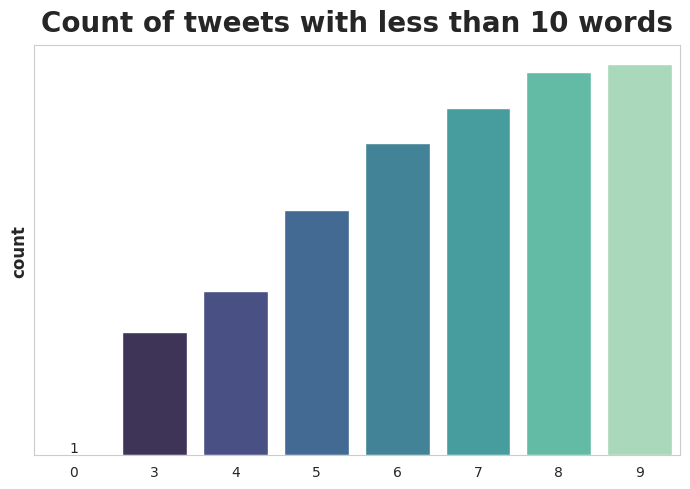

In [26]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<10], palette='mako')
plt.title('Count of tweets with less than 10 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

### What about long tweets?

In [27]:
df.sort_values(by=['text_len'], ascending=False)

,text,sentiment,text_clean,text_len
44035,You so black and white trying to live like a n...,ethnicity,black white trying live like nigger pahahahaha...,173
45165,"@hermdiggz: “@tayyoung_: FUCK OBAMA, dumb ass ...",ethnicity,fuck obama dumb as nigger bitch ltthis whore s...,151
1317,@EurekAlertAAAS: Researchers push to import to...,not_cyberbullying,researcher push import top antibullying progra...,138
33724,"... I don't feel guilty for killing him, I jus...",age,feel guilty killing feel guilty enjoyed tormen...,136
10922,don't make rape jokes!!! don't make gay jokes!...,gender,make rape joke make gay joke oh fat joke okay ...,121
...,...,...,...,...
4620,@pr1ntf stop making out with my bot,not_cyberbullying,stop making bot,3
13893,"one, rofl yeah.",gender,one rofl yeah,3
13910,"@howmariefeels I think he's trolling, actually...",gender,think trolling actually,3
4664,"@aliendeallstar @gugou complô, agora? bullying?",not_cyberbullying,compl agora bullying,3


/tmp/ipython-input-2060477503.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')


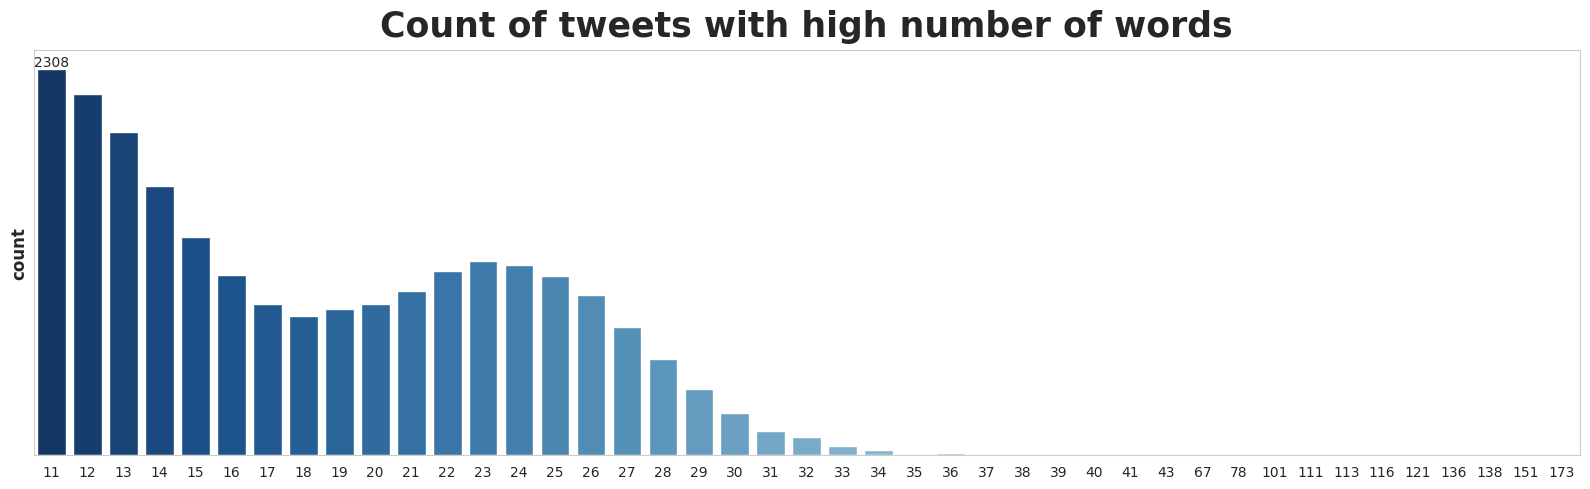

In [28]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=1000) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

We also will remove tweets that are too long (with more than 100 words).

In [29]:
df = df[df['text_len'] < df['text_len'].quantile(0.995)]

Then we also get the length of the longest tweet since it will be useful later.

In [30]:
max_len = np.max(df['text_len'])
max_len

31

In [31]:
df.sort_values(by=["text_len"], ascending=False)

,text,sentiment,text_clean,text_len
14702,one cis man says the bare minimum to support u...,gender,one ci man say bare minimum support trans peop...,31
47445,"White shall henceforth be called cracker, honk...",ethnicity,white shall henceforth called cracker honky gr...,31
8393,"#LGBTIQ proven RAPE JOKE CULTURED, led by RAIN...",gender,lgbtiq proven rape joke cultured led rainbow a...,31
42259,Bro fuck Xbox you guys are so fucking babyish ...,ethnicity,bro fuck xbox guy fucking babyish funny sick g...,31
41686,@BarackObama can’t believe you would cheer for...,ethnicity,can not believe would cheer team called white ...,31
...,...,...,...,...
2014,My pillows are super cold 😒,not_cyberbullying,pillow super cold,3
2019,Just like highschool days :),not_cyberbullying,like highschool day,3
2021,and note2 @TheNewSchool ... i'm coming for you...,not_cyberbullying,note coming take,3
2033,@WVTVW Thanks for parading your racism.,not_cyberbullying,thanks parading racism,3


## Sentiment column encoding

The target column will be encoded by ordinal encoding

In [32]:
df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

/tmp/ipython-input-4141559953.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sentiment'] = df['sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})


In [33]:
df.head()

,text,sentiment,text_clean,text_len
0,"In other words #katandandre, your food was cra...",4,word katandandre food crapilicious mkr,5
1,Why is #aussietv so white? #MKR #theblock #ImA...,4,aussietv white mkr theblock imacelebrityau tod...,11
2,@XochitlSuckkks a classy whore? Or more red ve...,4,classy whore red velvet cupcake,5
3,"@Jason_Gio meh. :P thanks for the heads up, b...",4,meh thanks head concerned another angry dude t...,8
4,@RudhoeEnglish This is an ISIS account pretend...,4,isi account pretending kurdish account like is...,8


## Train - Test split

Now we need to split the dataset into a train and test sets.

In [34]:
X = df['text_clean']
y = df['sentiment']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

## Train - Validation split

Moreover, we will further split the training set to extract a validation set, which will be used to monior the accuracy and loss to avoid overfitting during the model training.

In [36]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

In [37]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 4966],
       [   2, 4709],
       [   3, 4626],
       [   4, 3877]])

The classes are unbalanced, so it could be a good idea to oversample the training set such that all classes have the same count as the most populated one.

# Oversampling del training set para reducir el desbalanceo de los datos de training

---



In [38]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1));
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text_clean', 'sentiment']);

In [39]:
X_train = train_os['text_clean'].values
y_train = train_os['sentiment'].values

In [40]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 5015],
       [   2, 5015],
       [   3, 5015],
       [   4, 5015]])

# Naive Bayes baseline model

The first algorithm we will implement is Naive Bayes, which will be used as a simple baseline model. In order to use this algorithm, we need first need to preprocess the text data. <br>
First, we will create a bag of words using CountVectorizer.

In [41]:
clf = CountVectorizer()
X_train_cv =  clf.fit_transform(X_train)
X_test_cv = clf.transform(X_test)

Then we apply TF-IFD transformation to associate weigths to the different words based on their frequency (rarer words will be given more importance).

In [42]:
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv)
X_train_tf = tf_transformer.transform(X_train_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

Finally we can instantiate the Naive Bayes model.

In [43]:
nb_clf = MultinomialNB()

In [44]:
nb_clf.fit(X_train_tf, y_train)

MultinomialNB()

In [45]:
nb_pred = nb_clf.predict(X_test_tf)

In [46]:
print('Classification Report for Naive Bayes:\n',classification_report(y_test, nb_pred, target_names=sentiments))

Classification Report for Naive Bayes:
               precision    recall  f1-score   support

    religion       0.86      0.96      0.91      1568
         age       0.81      0.97      0.88      1552
   ethnicity       0.88      0.93      0.90      1471
      gender       0.88      0.84      0.86      1446
not bullying       0.82      0.46      0.59      1211

    accuracy                           0.85      7248
   macro avg       0.85      0.83      0.83      7248
weighted avg       0.85      0.85      0.84      7248



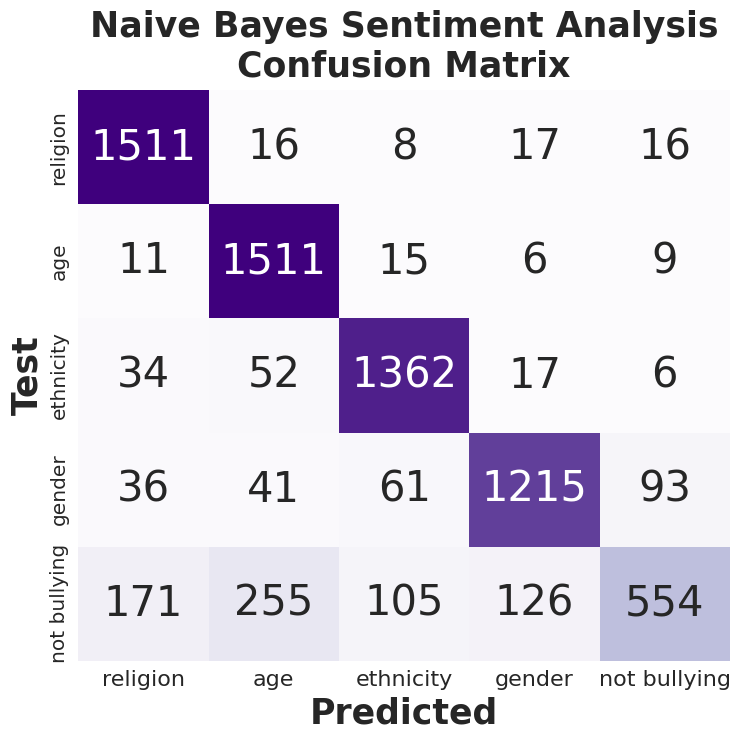

In [47]:
conf_matrix(y_test,nb_pred,'Naive Bayes Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of the algorithm is very good, with an overall accurcy of 85%.<br>
We can observe how the predictions for the more populated classes have very high F1 scores (over 85%), while for the class "non-cyberbullying" the score is much lower (61%).**

*Next we will implement a more complex algorithm to perform the classification, aiming to achieve higher accurcy than the baseline Naive Bayes model.*

# BERT Classification

In this section, we will load a pre trained BERT model from the Hugging Face library and fine tune it for our classification task.

First, we need to split the dataset into train - validation - test again since we need to tokenize the sentences differently from before (Naive Bayes and LSTM).

## Train - Validation - Test split

In [48]:
X = df['text_clean'].values
y = df['sentiment'].values

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=seed_value)

As seen before, we oversample the text to the majority class.

In [51]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train).reshape(-1,1),np.array(y_train).reshape(-1,1))

In [52]:
X_train_os = X_train_os.flatten()
y_train_os = y_train_os.flatten()

In [53]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 5015],
       [   1, 5015],
       [   2, 5015],
       [   3, 5015],
       [   4, 5015]])

# BERT Tokenización

Since we need to tokenize the tweets (get "input ids" and "attention masks") for BERT, we load the specific BERT tokenizer from the Hugging Face library.

In [54]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Then we define a custom tokenizer function using the loaded tokenizer.
Se añade el token spcial [CLS] para después poder clasificar el tipo de Tweet

In [55]:
def bert_tokenizer(data):
    input_ids = []
    attention_masks = []
    for sent in data:
        encoded_sent = tokenizer.encode_plus(
            text=sent,
            add_special_tokens=True,        # Add `[CLS]` and `[SEP]` special tokens
            max_length=MAX_LEN,             # Choose max length to truncate/pad
            padding='max_length',         # Pad sentence to max length
            return_attention_mask=True      # Return attention mask
            )
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))

    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

Since we need to specify the length of the longest tokenized sentence, we tokenize the train tweets using the "encode" method of the original BERT tokenizer and check the longest sentence.

In [56]:
# Tokenize train tweets
encoded_tweets = [tokenizer.encode(sent, add_special_tokens=True) for sent in X_train]

# Find the longest tokenized tweet
max_len = max([len(sent) for sent in encoded_tweets])
print('Max length: ', max_len)

Max length:  82


We can choose the max length as 128.

In [57]:
MAX_LEN = 128

Then we can tokenize the train, validation and test tweets using the custom define tokenizer.

In [58]:
train_inputs, train_masks = bert_tokenizer(X_train_os)
val_inputs, val_masks = bert_tokenizer(X_valid)
test_inputs, test_masks = bert_tokenizer(X_test)

## Data preprocessing for PyTorch BERT model

Since we are using the BERT model built on PyTorch, we need to convert the arrays to pytorch tensors and create dataloaders for the data.

In [59]:
# Convert target columns to pytorch tensors format
train_labels = torch.from_numpy(y_train_os)
val_labels = torch.from_numpy(y_valid)
test_labels = torch.from_numpy(y_test)

## Dataloaders

To fine-tune the BERT model, the original authors recommend a batch size of 16 or 32.

In [60]:
batch_size = 32

In [61]:
# Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

# Create the DataLoader for our test set
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# BERT Modeling

# Clasificador de Sentimientos con BERT y PyTorch usando el token `[CLS]`

En este capítulo, implementamos una arquitectura de red neuronal en **PyTorch** para la **clasificación de sentimientos de tweets** utilizando **BERT** como modelo base. Para ello, definimos una clase llamada `BERTSentimentClassifier`.

A diferencia de otros enfoques como el modelo `LSTM_Sentiment_Classifier` con mecanismo de atención, en el que se asignan pesos a diferentes partes de la secuencia de entrada, el modelo basado en BERT aprovecha directamente el token especial `[CLS]`. Este token es agregado al inicio de cada secuencia de entrada y se entrena específicamente para capturar una **representación global del significado de la frase completa**, lo que lo hace ideal para tareas de clasificación.

---

## ¿Cómo funciona BERT en este contexto?

**BERT** (Bidirectional Encoder Representations from Transformers) procesa todo el texto simultáneamente (de manera **bidireccional**), prestando atención a cada palabra en relación con todas las demás. El token `[CLS]`, que siempre se encuentra al inicio de la secuencia, **aprende una representación contextualizada de todo el texto**.

En nuestra clase `BERTSentimentClassifier`, utilizamos la salida correspondiente al token `[CLS]` como un **vector de características resumido** del tweet. Este vector se pasa a través de una **capa completamente conectada** (*fully connected*) y una **función de activación** (`Softmax` o `LogSoftmax`) para producir las **probabilidades finales** asociadas a cada clase de sentimiento.

---

## Arquitectura del Modelo

La clase `BERTSentimentClassifier` incluye los siguientes componentes:

- **Modelo BERT preentrenado** (`bert-base-uncased`, por ejemplo), cargado desde la librería `transformers`.
- **Capa Dropout**, para prevenir *overfitting*.
- **Capa lineal de clasificación**, que toma la salida del token `[CLS]` y produce los *logits* para cada clase.
- **Función de activación final**, como `LogSoftmax` o `Softmax`, según la función de pérdida utilizada.

---

## Método `forward`

En el método `forward`, se realiza lo siguiente:

1. El texto de entrada se **tokeniza** y se convierte a tensores de `input_ids` y `attention_mask`.
2. Estos tensores se **pasan al modelo BERT**.
3. Se **extrae la salida del token `[CLS]`**, que se encuentra en la primera posición de la salida:  
   `last_hidden_state[:, 0, :]`
4. Esta representación del `[CLS]` se pasa por la **capa dropout**, luego por la **capa lineal** y finalmente por la **función de activación**.
5. Se devuelve la **distribución de probabilidad sobre las clases de salida**.

---

## Ventajas del uso de BERT con el token `[CLS]`

Usar BERT con el token `[CLS]` permite **capturar automáticamente relaciones complejas** dentro del texto sin necesidad de implementar manualmente mecanismos de atención como en los modelos LSTM.  

BERT ha sido preentrenado con grandes volúmenes de texto, por lo que su capacidad para **entender el contexto** es significativamente superior.

Esto lo hace particularmente adecuado para tareas como el **análisis de sentimientos**, donde el contexto y la ambigüedad del lenguaje juegan un papel crítico.


Now we can create a custom BERT classifier class, including the original BERT model (made of transformer layers) and additional Dense layers to perform the desired classification task.

In [62]:
class Bert_Classifier(nn.Module):
    def __init__(self, freeze_bert=False):
        super(Bert_Classifier, self).__init__()
        # Specify hidden size of BERT, hidden size of the classifier, and number of labels
        n_input = 768
        n_hidden = 50
        n_output = 5

        # Instantiate BERT model
        self.bert = BertModel.from_pretrained('bert-base-uncased')

        # Instantiate the classifier (a fully connected layer followed by a ReLU activation and another fully connected layer)
        self.classifier = nn.Sequential(
            nn.Linear(n_input, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_output)
        )

        # Freeze the BERT model weights if freeze_bert is True (useful for feature extraction without fine-tuning)
        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, input_ids, attention_mask):
        # Feed input data (input_ids and attention_mask) to BERT
        outputs = self.bert(input_ids=input_ids,
                            attention_mask=attention_mask)

        # Extract the last hidden state of the `[CLS]` token from the BERT output (useful for classification tasks)
        last_hidden_state_cls = outputs[0][:, 0, :] # este token es el que va avaler para clasificar

        # Feed the extracted hidden state to the classifier to compute logits
        logits = self.classifier(last_hidden_state_cls)

        return logits

Moreover, since we want to define a learning rate scheduler, we define a custom "initalize_model" function as follows.

In [63]:
# Function for initializing the BERT Classifier model, optimizer, and learning rate scheduler
def initialize_model(epochs=4):
    # Instantiate Bert Classifier
    bert_classifier = Bert_Classifier(freeze_bert=False)

    bert_classifier.to(device)

    # Set up optimizer
    optimizer = AdamW(bert_classifier.parameters(),
                      lr=5e-5,    # learning rate, set to default value
                      eps=1e-8    # decay, set to default value
                      )

    # Calculate total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Define the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
    return bert_classifier, optimizer, scheduler

We also specify the use of GPU if present (highly recommended for the fine tuning)

In [64]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
EPOCHS=2

And then we intialize the BERT model calling the "initialize_model" function we defined.

In [65]:
bert_classifier, optimizer, scheduler = initialize_model(epochs=EPOCHS)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# BERT Training

After defining the custom BERT classifier model, we are ready to start the training.

In [66]:
# Define Cross entropy Loss function for the multiclass classification task
loss_fn = nn.CrossEntropyLoss()

def bert_train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):

    print("Start training...\n")
    for epoch_i in range(epochs):
        print("-"*10)
        print("Epoch : {}".format(epoch_i+1))
        print("-"*10)
        print("-"*38)
        print(f"{'BATCH NO.':^7} | {'TRAIN LOSS':^12} | {'ELAPSED (s)':^9}")
        print("-"*38)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        ###TRAINING###

        # Put the model into the training mode
        model.train()

        for step, batch in enumerate(train_dataloader):
            batch_counts +=1

            b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass and get logits.
            logits = model(b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update model parameters:
            # fine tune BERT params and train additional dense layers
            optimizer.step()
            # update learning rate
            scheduler.step()

            # Print the loss values and time elapsed for every 100 batches
            if (step % 100 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                print(f"{step:^9} | {batch_loss / batch_counts:^12.6f} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)

        ###EVALUATION###

        # Put the model into the evaluation mode
        model.eval()

        # Define empty lists to host accuracy and validation for each batch
        val_accuracy = []
        val_loss = []

        for batch in val_dataloader:
            batch_input_ids, batch_attention_mask, batch_labels = tuple(t.to(device) for t in batch)

            # We do not want to update the params during the evaluation,
            # So we specify that we dont want to compute the gradients of the tensors
            # by calling the torch.no_grad() method
            with torch.no_grad():
                logits = model(batch_input_ids, batch_attention_mask)

            loss = loss_fn(logits, batch_labels)

            val_loss.append(loss.item())

            # Get the predictions starting from the logits (get index of highest logit)
            preds = torch.argmax(logits, dim=1).flatten()

            # Calculate the validation accuracy
            accuracy = (preds == batch_labels).cpu().numpy().mean() * 100
            val_accuracy.append(accuracy)

        # Compute the average accuracy and loss over the validation set
        val_loss = np.mean(val_loss)
        val_accuracy = np.mean(val_accuracy)

        # Print performance over the entire training data
        time_elapsed = time.time() - t0_epoch
        print("-"*61)
        print(f"{'AVG TRAIN LOSS':^12} | {'VAL LOSS':^10} | {'VAL ACCURACY (%)':^9} | {'ELAPSED (s)':^9}")
        print("-"*61)
        print(f"{avg_train_loss:^14.6f} | {val_loss:^10.6f} | {val_accuracy:^17.2f} | {time_elapsed:^9.2f}")
        print("-"*61)
        print("\n")

    print("Training complete!")

In [67]:
bert_train(bert_classifier, train_dataloader, val_dataloader, epochs=EPOCHS)

Start training...

----------
Epoch : 1
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.604546   |   57.58  
   200    |   0.305102   |   59.95  
   300    |   0.260042   |   59.36  
   400    |   0.217698   |   59.73  
   500    |   0.201943   |   59.55  
   600    |   0.212967   |   59.52  
   700    |   0.177848   |   59.73  
   783    |   0.185192   |   49.39  
-------------------------------------------------------------
AVG TRAIN LOSS |  VAL LOSS  | VAL ACCURACY (%) | ELAPSED (s)
-------------------------------------------------------------
   0.272946    |  0.204444  |       93.62       |  500.32  
-------------------------------------------------------------


----------
Epoch : 2
----------
--------------------------------------
BATCH NO. |  TRAIN LOSS  | ELAPSED (s)
--------------------------------------
   100    |   0.130602   |   59.82  
   200    |   0.140460   |   59.68  
   3

# BERT Prediction

Now we define a function similar to the model "evaluation", where we feed to the model the test data instead of the validation data.

In [68]:
def bert_predict(model, test_dataloader):

    # Define empty list to host the predictions
    preds_list = []

    # Put the model into evaluation mode
    model.eval()

    for batch in test_dataloader:
        batch_input_ids, batch_attention_mask = tuple(t.to(device) for t in batch)[:2]

        # Avoid gradient calculation of tensors by using "no_grad()" method
        with torch.no_grad():
            logit = model(batch_input_ids, batch_attention_mask)

        # Get index of highest logit
        pred = torch.argmax(logit,dim=1).cpu().numpy()
        # Append predicted class to list
        preds_list.extend(pred)

    return preds_list

Then we can call the defined function and get the class predictions of the test data.

In [69]:
bert_preds = bert_predict(bert_classifier, test_dataloader)

In [70]:
print('Classification Report for BERT :\n', classification_report(y_test, bert_preds, target_names=sentiments))

Classification Report for BERT :
               precision    recall  f1-score   support

    religion       0.96      0.96      0.96      1568
         age       0.99      0.97      0.98      1552
   ethnicity       0.99      0.99      0.99      1471
      gender       0.92      0.91      0.92      1446
not bullying       0.83      0.86      0.84      1211

    accuracy                           0.94      7248
   macro avg       0.94      0.94      0.94      7248
weighted avg       0.94      0.94      0.94      7248



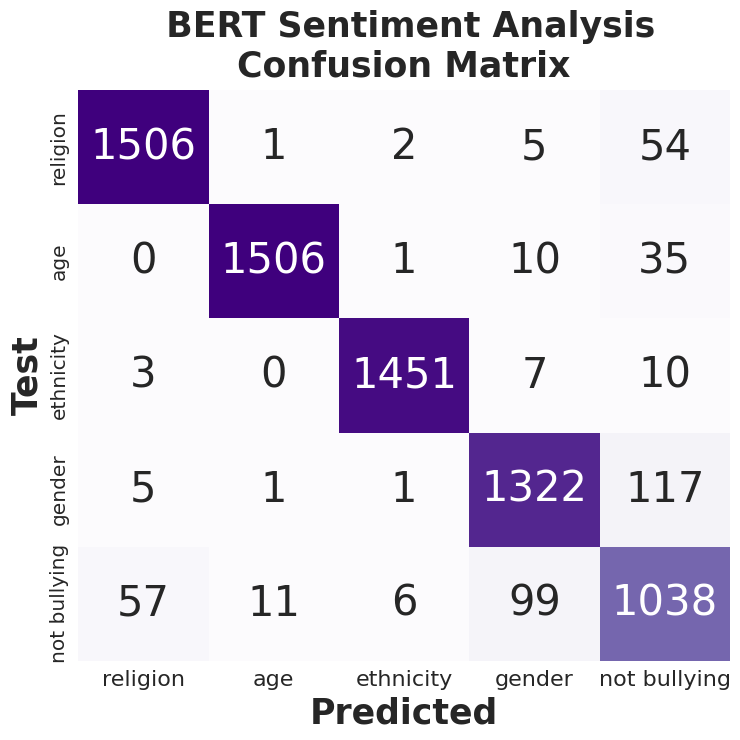

In [71]:
conf_matrix(y_test, bert_preds,' BERT Sentiment Analysis\nConfusion Matrix', sentiments)

**The performance scores of BERT Classifier are quite high and higher than those achieved using the Naive Baseline model, with an overall accuracy around 94% and F1 scores well over 94%.**<br>

Thank your for checking out my notebook! Let me know if you have comments or if you want me to check out your work! :)